In [1]:
pip install tensorflow opencv-python scikit-learn numpy

In [2]:
!pip install opencv-python
!pip install matplotlib
!pip install kaggle


In [3]:
from google.colab import files

In [4]:
# Upload your Kaggle API token JSON file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download shyambhu/hands-and-palm-images-dataset

100% 633M/634M [00:05<00:00, 164MB/s]
100% 634M/634M [00:05<00:00, 131MB/s]


In [7]:
!unzip -qq "/content/hands-and-palm-images-dataset.zip"

In [8]:
import cv2
import matplotlib.pyplot as plt

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load dataset and CSV file
data = pd.read_csv(r"/content/HandInfo.csv")

# Data preprocessing
image_dir = r"/content/Hands/Hands"


In [11]:
print(data.head())

   id  age gender skinColor  accessories  nailPolish  aspectOfHand  \
0   0   27   male      fair            0           0  dorsal right   
1   0   27   male      fair            0           0  dorsal right   
2   0   27   male      fair            0           0  dorsal right   
3   0   27   male      fair            0           0  dorsal right   
4   0   27   male      fair            0           0  dorsal right   

          imageName  irregularities  
0  Hand_0000002.jpg               0  
1  Hand_0000003.jpg               0  
2  Hand_0000004.jpg               0  
3  Hand_0000005.jpg               0  
4  Hand_0000006.jpg               0  


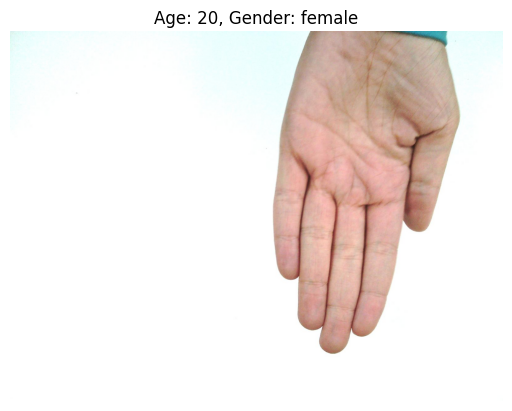

In [12]:
import matplotlib.pyplot as plt
import random

# Assuming 'data' contains your dataset and 'image_dir' is the directory of your images

# Select a random index
random_index = random.randint(0, len(data) - 1)

# Get the image file name and label
image_name = data.loc[random_index, 'imageName']
age_label = data.loc[random_index, 'age']
gender_label = data.loc[random_index, 'gender']

# Load and display the image
image_path = os.path.join(image_dir, image_name)
image = plt.imread(image_path)

plt.imshow(image)
plt.title(f'Age: {age_label}, Gender: {gender_label}')
plt.axis('off')
plt.show()


In [13]:
pip install efficientnet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00


In [23]:
import tensorflow as tf
from tensorflow.keras import layers
from efficientnet.tfkeras import EfficientNetB0

# Function to create a Squeeze-and-Excitation block
def squeeze_excite_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, channels))(se)
    se = layers.Conv2D(channels // ratio, 1, activation='relu', padding='same')(se)
    se = layers.Conv2D(channels, 1, activation='sigmoid', padding='same')(se)
    return layers.Multiply()([input_tensor, se])

# Function to create an EfficientNet model with SE block for gender prediction
def create_gender_model(input_shape=(224, 224, 3)):
    base_model = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

    # Freeze the convolutional base
    base_model.trainable = False

    # Apply the SE block
    x = squeeze_excite_block(base_model.output)

    # Continue with the rest of your model architecture
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Output Layer
    output_layer = layers.Dense(1, activation='sigmoid', name='gender_encoded')(x)

    # Create the model
    model = tf.keras.Model(inputs=base_model.input, outputs=output_layer)

    return model

# Create the model with Squeeze-and-Excitation
gender_model = create_gender_model()

# Compile the model
gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
gender_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_5[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']         

In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split



# Step 1: Drop rows where 'accessories' is True
data_filtered = data[data['accessories'] == False]

# Encode 'gender' labels
label_encoder = LabelEncoder()
data_filtered['gender_encoded'] = label_encoder.fit_transform(data_filtered['gender'])

# Image data generators
datagen = ImageDataGenerator(rescale=1./255)
image_size = (224, 224)
# Read labels and image names for training
train_labels = pd.read_csv(r"/content/drive/MyDrive/drive-download-20231218T134646Z-001/g_training_d.txt", header=None, names=['gender'])
train_image_names = pd.read_csv(r"/content/drive/MyDrive/drive-download-20231218T134646Z-001/g_imgs_training_d.txt", header=None, names=['imageName'])
train_data = pd.concat([train_labels, train_image_names], axis=1)

# Read labels and image names for testing
test_labels = pd.read_csv(r"/content/drive/MyDrive/drive-download-20231218T134646Z-001/g_testing_d.txt", header=None, names=['gender'])
test_image_names = pd.read_csv(r"/content/drive/MyDrive/drive-download-20231218T134646Z-001/g_imgs_testing_d.txt", header=None, names=['imageName'])
test_data = pd.concat([test_labels, test_image_names], axis=1)

train_data['gender_encoded'] = label_encoder.fit_transform(train_data['gender'])
test_data['gender_encoded'] = label_encoder.transform(test_data['gender'])

# Display a few rows of the training and testing datasets
print("Training Data:")
print(train_data)

print("\nTesting Data:")
print(test_data)


# print(image_dir)
print(image_size)
train_datagen_dorsal = datagen.flow_from_dataframe(
    train_data,
    directory=image_dir,
    x_col='imageName',
    y_col='gender',
    target_size=image_size,
    class_mode="binary",
    batch_size=32,
    subset=None  # Add this line to ensure RGB color mode
)

test_datagen_dorsal = datagen.flow_from_dataframe(
    test_data,
    directory=image_dir,
    x_col='imageName',
    y_col='gender',
    target_size=image_size,
    class_mode="binary",
    batch_size=32,
    subset=None # Add this line to ensure RGB color mode
)

gender_model.fit(train_datagen_dorsal, epochs=15)
evaluation_results = gender_model.evaluate(test_datagen_dorsal)



Training Data:
      gender         imageName  gender_encoded
0       male  Hand_0007640.jpg               1
1     female  Hand_0003221.jpg               0
2       male  Hand_0010958.jpg               1
3       male  Hand_0011003.jpg               1
4     female  Hand_0010228.jpg               0
...      ...               ...             ...
1995    male  Hand_0007694.jpg               1
1996    male  Hand_0002628.jpg               1
1997    male  Hand_0006893.jpg               1
1998  female  Hand_0008346.jpg               0
1999    male  Hand_0006883.jpg               1

[2000 rows x 3 columns]

Testing Data:
     gender         imageName  gender_encoded
0      male  Hand_0006963.jpg               1
1    female  Hand_0008318.jpg               0
2    female  Hand_0003558.jpg               0
3    female  Hand_0005340.jpg               0
4    female  Hand_0006371.jpg               0
..      ...               ...             ...
995    male  Hand_0009373.jpg               1
996    male  

<ipython-input-24-d75659a38a07>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['gender_encoded'] = label_encoder.fit_transform(data_filtered['gender'])


Epoch 1/15
63/63 [==============================] - 22s 243ms/step - loss: 0.4781 - accuracy: 0.7675
Epoch 2/15
63/63 [==============================] - 17s 264ms/step - loss: 0.2818 - accuracy: 0.8870
Epoch 3/15
63/63 [==============================] - 16s 252ms/step - loss: 0.2221 - accuracy: 0.9155
Epoch 4/15
63/63 [==============================] - 16s 260ms/step - loss: 0.1683 - accuracy: 0.9400
Epoch 5/15
63/63 [==============================] - 16s 258ms/step - loss: 0.1302 - accuracy: 0.9515
Epoch 6/15
63/63 [==============================] - 16s 252ms/step - loss: 0.1473 - accuracy: 0.9420
Epoch 7/15
63/63 [==============================] - 16s 255ms/step - loss: 0.1028 - accuracy: 0.9575
Epoch 8/15
63/63 [==============================] - 16s 249ms/step - loss: 0.1023 - accuracy: 0.9605
Epoch 9/15
63/63 [==============================] - 15s 240ms/step - loss: 0.0777 - accuracy: 0.9720
Epoch 10/15
63/63 [==============================] - 15s 243ms/step - loss: 0.0883 - accura